<h1>Import frameworks</h1>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torch.utils.data import DataLoader


#gpu_device = torch.device("cpu")
#if torch.backends.mps.is_available():
#    gpu_device = torch.device("mps")
#else:
#    print ("MPS device not found.")

<h1>Import datasets</h1>

In [2]:
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = datasets.MNIST(root='Assignment6/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='Assignment6/', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("train dataset: ", len(train_dataset))
print("test dataset: ", len(test_dataset))



train dataset:  60000
test dataset:  10000


<h1>Plot images</h1>

Image shape: torch.Size([32, 1, 28, 28])
Label shape: torch.Size([32])


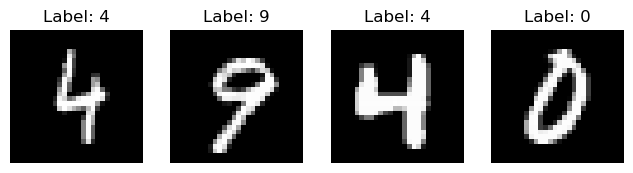

In [11]:

for images, labels in train_loader:
    print("Image shape:", images.size())
    print("Label shape:", labels.size()) 

    fig = plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray') 
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()
    fig.savefig('mnist_images.png', bbox_inches='tight')
    break  


<h1>Neural Network</h1>

In [13]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Add ReLU and batch normalization except for the last layer
                layers.append(nn.BatchNorm1d(layer_sizes[i+1])) 
                layers.append(nn.ReLU())
            else:
                layers.append(nn.LogSoftmax(dim=1)) #layers.append(nn.Softmax(dim=1))


        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.model(x)
        return x

<h1>Training</h1>

In [12]:
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs, name):
    train_losses = []  
    test_losses = []

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0

        for images, labels in train_loader:
            #images, labels = inputs.to(gpu_device), labels.to(gpu_device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                #images, labels = inputs.to(gpu_device), labels.to(gpu_device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        accuracy = correct / total
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")


    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
    ax.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    ax.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Test Losses')
    ax.legend()
    plt.show()
    fig.savefig(name  +  ".pdf", bbox_inches='tight')


<h1>Accuracy</h1>

In [14]:
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    
    return accuracy

<h1>Single hidden layer</h1>

Epoch [1/10], Training Loss: 0.2200, Test Loss: 0.1065, Test Accuracy: 0.9695
Epoch [2/10], Training Loss: 0.1057, Test Loss: 0.0921, Test Accuracy: 0.9725
Epoch [3/10], Training Loss: 0.0768, Test Loss: 0.0728, Test Accuracy: 0.9765
Epoch [4/10], Training Loss: 0.0613, Test Loss: 0.0666, Test Accuracy: 0.9793
Epoch [5/10], Training Loss: 0.0497, Test Loss: 0.0643, Test Accuracy: 0.9791
Epoch [6/10], Training Loss: 0.0421, Test Loss: 0.0639, Test Accuracy: 0.9798
Epoch [7/10], Training Loss: 0.0355, Test Loss: 0.0628, Test Accuracy: 0.9811
Epoch [8/10], Training Loss: 0.0309, Test Loss: 0.0569, Test Accuracy: 0.9823
Epoch [9/10], Training Loss: 0.0279, Test Loss: 0.0616, Test Accuracy: 0.9796
Epoch [10/10], Training Loss: 0.0225, Test Loss: 0.0590, Test Accuracy: 0.9816


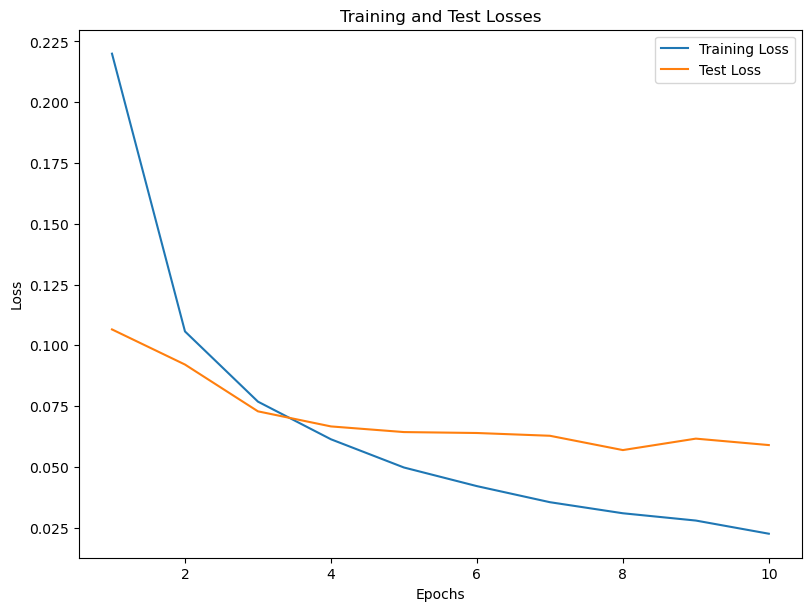

Accuracy for single hidden layer: 0.9816


In [15]:
input_size = 28 * 28 
hidden_sizes = [300] # Is this the best choice?
output_size = 10  

model = NeuralNet(input_size, hidden_sizes, output_size)
#model = model.to(gpu_device)

learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 10
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "single_hidden_layer")
accuracy = calculate_accuracy(model, test_loader)
print(f"Accuracy for single hidden layer: {accuracy:.4f}")

<h1>Two hidden layers</h1>

Epoch [1/40], Training Loss: 0.1909, Test Loss: 0.0823
Epoch [2/40], Training Loss: 0.0903, Test Loss: 0.0703
Epoch [3/40], Training Loss: 0.0623, Test Loss: 0.0627
Epoch [4/40], Training Loss: 0.0493, Test Loss: 0.0667
Epoch [5/40], Training Loss: 0.0372, Test Loss: 0.0533
Epoch [6/40], Training Loss: 0.0312, Test Loss: 0.0544
Epoch [7/40], Training Loss: 0.0268, Test Loss: 0.0507
Epoch [8/40], Training Loss: 0.0232, Test Loss: 0.0544
Epoch [9/40], Training Loss: 0.0199, Test Loss: 0.0543
Epoch [10/40], Training Loss: 0.0177, Test Loss: 0.0528
Epoch [11/40], Training Loss: 0.0154, Test Loss: 0.0435
Epoch [12/40], Training Loss: 0.0132, Test Loss: 0.0494
Epoch [13/40], Training Loss: 0.0127, Test Loss: 0.0489
Epoch [14/40], Training Loss: 0.0111, Test Loss: 0.0499
Epoch [15/40], Training Loss: 0.0124, Test Loss: 0.0504
Epoch [16/40], Training Loss: 0.0101, Test Loss: 0.0530
Epoch [17/40], Training Loss: 0.0091, Test Loss: 0.0487
Epoch [18/40], Training Loss: 0.0085, Test Loss: 0.0461
E

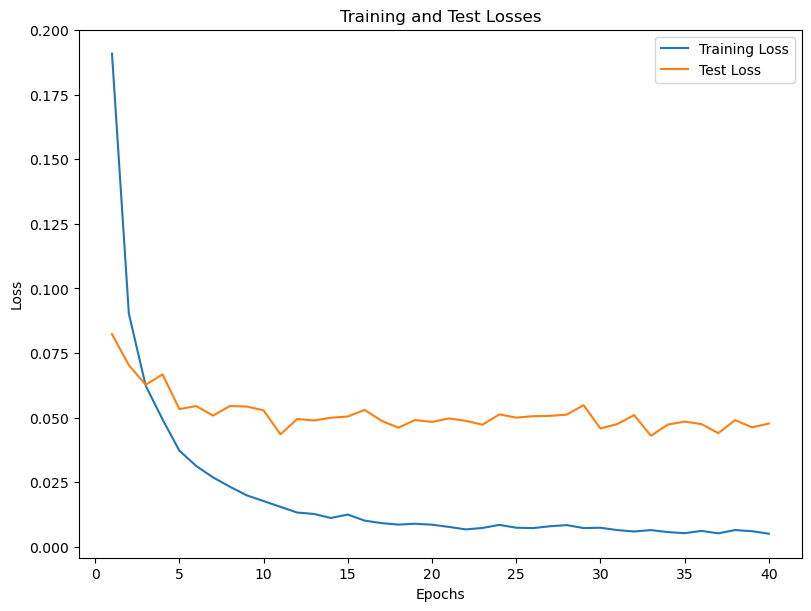

Accuracy for tow hidden layers: 0.9855


In [6]:
input_size = 28 * 28   
hidden_sizes = [500, 300]  
output_size = 10  
weight_decay = 0.0001
model = NeuralNet(input_size, hidden_sizes, output_size)

learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 40
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "two_hidden_layer")
accuracy = calculate_accuracy(model, test_loader)
print(f"Accuracy for two hidden layers: {accuracy:.4f}")

<h1>Convolutional neural network</h1>

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))
        x = x.view(-1, 256 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


<h1>Train convolutional neural network</h1>

Epoch [1/40], Training Loss: 0.1761, Test Loss: 0.0580
Epoch [2/40], Training Loss: 0.0492, Test Loss: 0.0413
Epoch [3/40], Training Loss: 0.0331, Test Loss: 0.0262
Epoch [4/40], Training Loss: 0.0253, Test Loss: 0.0315
Epoch [5/40], Training Loss: 0.0189, Test Loss: 0.0292
Epoch [6/40], Training Loss: 0.0160, Test Loss: 0.0289
Epoch [7/40], Training Loss: 0.0116, Test Loss: 0.0259
Epoch [8/40], Training Loss: 0.0096, Test Loss: 0.0392
Epoch [9/40], Training Loss: 0.0088, Test Loss: 0.0259
Epoch [10/40], Training Loss: 0.0066, Test Loss: 0.0262
Epoch [11/40], Training Loss: 0.0064, Test Loss: 0.0567
Epoch [12/40], Training Loss: 0.0048, Test Loss: 0.0337
Epoch [13/40], Training Loss: 0.0039, Test Loss: 0.0335
Epoch [14/40], Training Loss: 0.0023, Test Loss: 0.0298
Epoch [15/40], Training Loss: 0.0020, Test Loss: 0.0284
Epoch [16/40], Training Loss: 0.0018, Test Loss: 0.0273
Epoch [17/40], Training Loss: 0.0017, Test Loss: 0.0279
Epoch [18/40], Training Loss: 0.0009, Test Loss: 0.0268
E

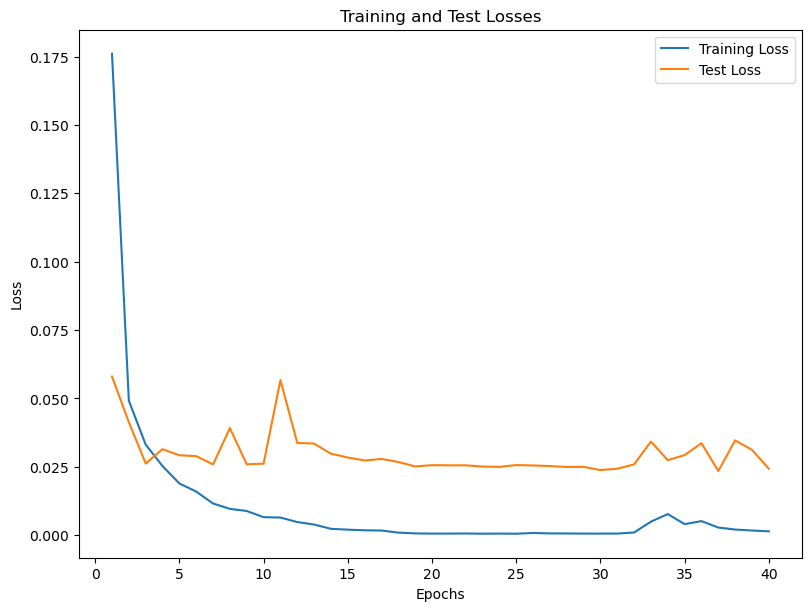

Accuracy for convolutional neural network: 0.9929


In [8]:

model = CNN() 

weight_decay = 0.0001
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 40
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "cnn")
accuracy = calculate_accuracy(model, test_loader)
print(f"Accuracy for convolutional neural network: {accuracy:.4f}")

<h1>Testing layers dimension</h1>

In [ ]:


conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
pool = nn.MaxPool2d(kernel_size=2, stride=2)

x = torch.randn(32, 1, 28, 28)  # Batch size of 32, 1 channel, 28x28 image

print("Output:", x.size())
x = conv1(x)
print("Output after conv1:", x.size())
x = conv2(x)
print("Output after conv2:", x.size())
x = conv3(x)
print("Output after conv3:", x.size())
x = pool(x)
print("Output after pool1:", x.size())
x = pool(x)
print("Output after pool2:", x.size())
x = pool(x)
print("Output after pool3:", x.size())

